# Creating spatial index for ascii clusters

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />

**In this notebook, we use ascii files (or derivatives) in order to assign spatial index to CLEWs clusters.** 

In brief, the process has as follows:

- First, we import a sample ascii grid file using rasterio and convert it into a tif. 
- Then we use a bundle of functions to parse the tif in the form of an array, and use gdal to convert the array to a point vector. Together with the coordinates for each vector point, we extract the equivalent row/col index from the initial file. This allows to create an "id" which can be used as a merger attribute with data that do not have spatial index (e.g. CLEWs clusters). 
- After merging and cleaning the notebook yields a point vector layer with the spatial resolution of the input ascii layer and information of the additional layers.

The output layer creates the base for further spatially explicit information extraction!

## Import necessary modules 

In [1]:
# Importing modules

# Numerical
import numpy as np
import pandas as pd

# Spatial
import geopandas as gpd
import rasterio
from shapely.geometry import Polygon, Point
import ogr, gdal, osr, os

# System & Other
import os

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Provide paths and file names

In [2]:
# Directories
ROOT_DIR = os.path.abspath(os.curdir)
in_path = os.path.join(ROOT_DIR, 'sample_input')
out_path = os.path.join(ROOT_DIR, 'sample_output')

# ascii file name
asci_nm = 'data.asc'

# raster name
raster_nm = "data.tif"

# vector point name
shp_nm = "data.shp"

# CLEWs cluster name
clust_nm = "ethiopia_clusters.csv"

# Final shp product layer
out_nm = "Ethiopia_vector_points_clusters" 

## Open ascii grid file | re-write as tif

In [3]:
# Import ascii and export as tif

with rasterio.open(in_path + '\\' + asci_nm) as src:
    data = src.read(1)                  # The number defined the band, not that changing data might require change of band

    #Export ascii as tif for easier processing
    with rasterio.open(out_path +"\\" + raster_nm, 
                       'w', 
                       driver='GTiff', 
                       height=data.shape[0], 
                       width=data.shape[1], 
                       count=data.shape[1],
                       dtype=data.dtype,
                       crs=src.crs,
                       transform=src.transform) as dst:
        dst.write(data, 3) 

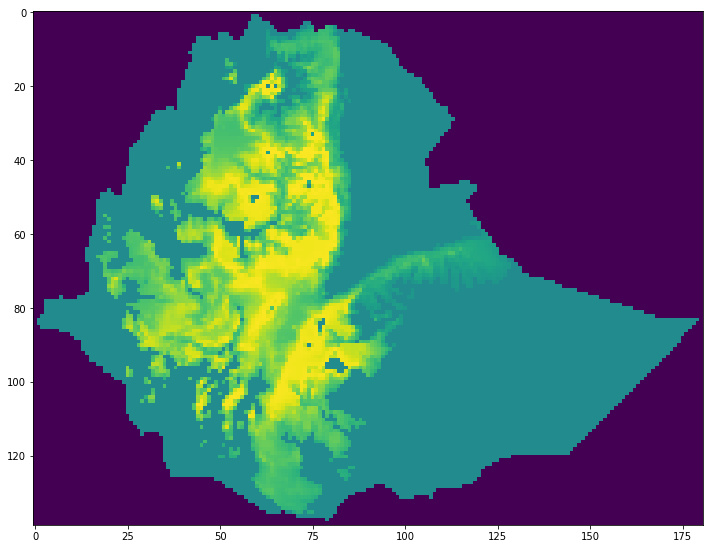

In [4]:
plt.figure(figsize = (12,12))
plt.imshow(data, cmap='viridis')
plt.show()

**Note!**

Rasterio imports raster files as 2-d arrays. The dimensions of the array are related to the spatial resolution of the imported layer. Individual values can be access in common practice as in numpy arrays. 

## Import tif and transform it to point vector

In [5]:
# Define functions

def pixelOffset2coord(raster, xOffset,yOffset):
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    coordX = originX+pixelWidth*xOffset
    coordY = originY+pixelHeight*yOffset
    return coordX, coordY

def raster2array(rasterfn, band_no):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(band_no)    # Be aware of the band you need here
    array = band.ReadAsArray()
    return array

def array2shp(array,outSHPfn,rasterfn):

    # max distance between points
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    pixelWidth = geotransform[1]

    srs = osr.SpatialReference()
    srs.ImportFromWkt(raster.GetProjection())
    
    # wkbPoint
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outSHPfn):
        shpDriver.DeleteDataSource(outSHPfn)
    outDataSource = shpDriver.CreateDataSource(outSHPfn)
    outLayer = outDataSource.CreateLayer(outSHPfn, geom_type=ogr.wkbPoint, srs=srs )
    featureDefn = outLayer.GetLayerDefn()
    outLayer.CreateField(ogr.FieldDefn("VALUE", ogr.OFTString))

    # array2dict
    point = ogr.Geometry(ogr.wkbPoint)
    row_count = array.shape[0]
    for ridx, row in enumerate(array):
        if ridx % 10 == 0:
            print ("{0} of {1} rows processed".format(ridx, row_count))
        for cidx, value in enumerate(row):
            index = str(ridx) + "_" + str(cidx)
            Xcoord, Ycoord = pixelOffset2coord(raster,cidx,ridx)
            point.AddPoint(Xcoord, Ycoord)
            # Create the feature and set values
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(point)
            outFeature.SetField("VALUE", str(index))
            outLayer.CreateFeature(outFeature)
            outFeature.Destroy()
            #outDS.Destroy()
    print ("\nProcess completed!")

def main(rasterfn,outSHPfn, band_no):
    array = raster2array(rasterfn, band_no)
    array2shp(array,outSHPfn,rasterfn)

In [6]:
# Provide the input raster and give a name to the output transformed vector
raster = out_path + "\\" + raster_nm
outSHP = out_path + "\\" + shp_nm

# Run the function
main(raster,outSHP, band_no=3)

0 of 139 rows processed
10 of 139 rows processed
20 of 139 rows processed
30 of 139 rows processed
40 of 139 rows processed
50 of 139 rows processed
60 of 139 rows processed
70 of 139 rows processed
80 of 139 rows processed
90 of 139 rows processed
100 of 139 rows processed
110 of 139 rows processed
120 of 139 rows processed
130 of 139 rows processed

Process completed!


## Import vector point layer into a geo-dataframe

In [7]:
# Create a new geo-dataframe
data_gdf = gpd.read_file(out_path + "\\" + shp_nm)

In [8]:
data_gdf.head(3)

,VALUE,geometry
0,0_0,POINT (32.91667 14.91667)
1,0_1,POINT (33.00000 14.91667)
2,0_2,POINT (33.08333 14.91667)


**Note!**

VALUE has been retrieved from the ascii file; it denotes the number of row and column in the initial layer, split by the underscore delimiter.

#### Split VALUE and create two separate columns for [row] and [col]

In [9]:
# Split the Value to rows and columns
split = data_gdf["VALUE"].str.split("_", n = 1, expand = True)

In [10]:
# Drop the VALUE as it has served its purpose
data_gdf = data_gdf.drop(["VALUE"], axis=1)

In [11]:
# Add the separate columns back to the dataframe
data_gdf["row"] = split[0]
data_gdf["col"] = split[1]

In [12]:
# Change dtype of columns from str to int
data_gdf["row"] = data_gdf["row"].astype(np.int)
data_gdf["col"] = data_gdf["col"].astype(np.int)

In [13]:
# Create a tuple id to use for merging later on
data_gdf["id"] = list(zip(data_gdf.row, data_gdf.col))

In [14]:
data_gdf.head(3)

,geometry,row,col,id
0,POINT (32.91667 14.91667),0,0,"(0, 0)"
1,POINT (33.00000 14.91667),0,1,"(0, 1)"
2,POINT (33.08333 14.91667),0,2,"(0, 2)"


In [15]:
data_gdf.describe()

,row,col
count,25159.000000,25159.00000
mean,69.000000,90.00000
std,40.125603,52.25044
min,0.000000,0.00000
25%,34.000000,45.00000
50%,69.000000,90.00000
75%,104.000000,135.00000
max,138.000000,180.00000


## Import CLEWs clusters as dataframe

In [16]:
# Import csv as pandas dataframe
cluster_data = pd.read_csv(in_path + "\\" + clust_nm)

In [17]:
cluster_data.head(3)

,row,col,cluster
0,1,59,TIGC02
1,1,60,TIGC02
2,2,59,TIGC02


In [18]:
# Create a tuple id to be used for merging
cluster_data['id'] = list(zip(cluster_data.row, cluster_data.col))

In [19]:
cluster_data.head(3)

,row,col,cluster,id
0,1,59,TIGC02,"(1, 59)"
1,1,60,TIGC02,"(1, 60)"
2,2,59,TIGC02,"(2, 59)"


In [20]:
cluster_data.describe()

,row,col
count,13353.000000,13353.000000
mean,75.001872,80.049053
std,32.330070,36.451778
min,1.000000,1.000000
25%,51.000000,52.000000
50%,79.000000,77.000000
75%,100.000000,105.000000
max,137.000000,179.000000


## Merging dataframes

**Note!** 

The two dataframe do not have the same number of columns, therefore we merge using the "fuller" one as guide.

In [21]:
clustered_GAEZ_gdf = data_gdf.merge(cluster_data, on=["id"], how="left")

In [22]:
clustered_GAEZ_gdf.head(3)

,geometry,row_x,col_x,id,row_y,col_y,cluster
0,POINT (32.91667 14.91667),0,0,"(0, 0)",NaN,NaN,NaN
1,POINT (33.00000 14.91667),0,1,"(0, 1)",NaN,NaN,NaN
2,POINT (33.08333 14.91667),0,2,"(0, 2)",NaN,NaN,NaN


In [23]:
# Droping un-necessary columns and cleaning
clustered_GAEZ_gdf = clustered_GAEZ_gdf.drop(['id','row_y', 'col_y'], axis=1)

# Renaming columns
clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col'}, inplace=True)

# Fillna 
#clustered_GAEZ_gdf["cluster"] = clustered_GAEZ_gdf["cluster"].fillna(0)

In [24]:
clustered_GAEZ_gdf.cluster.unique()

array([nan, 'TIGC02', 'TIGC01', 'AFAC02', 'AFAC01', 'AMHC02', 'AMHC01',
       'BENC01', 'BENC03', 'BENC02', 'SOMC03', 'SOMC01', 'SOMC02',
       'OROC02', 'OROC03', 'OROC01', 'ADDC01', 'GAMC01', 'SOUC01',
       'GAMC02', 'SOUC02', 'SOUC03'], dtype=object)

## Export geo-dataframe as shapefile

In [25]:
# Export as shapefile 
clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.shp".format(c=out_nm)))